In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

/home/cjw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#checkpoint = '/Users/cjw/Data/sez/sez_checkpoints/2019-01-31/unet_checkpoint-3000'
checkpoint = '/ssd1/cjw/Data/sez/Checkpoints/2019-03-07-ft/dnet_cat_checkpoint-2500'
cpmeta = checkpoint + '.meta'

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from /ssd1/cjw/Data/sez/Checkpoints/2019-03-07-ft/dnet_cat_checkpoint-2500


In [4]:
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    try:
        print(op.name, op.outputs, len(op.outputs))
    except:
        print(op.name, "no output")
    print('------')

init [] 0
------
Placeholder [<tf.Tensor 'Placeholder:0' shape=(?, 256, 256, 3) dtype=float32>] 1
------
Placeholder_1 [<tf.Tensor 'Placeholder_1:0' shape=(?, 256, 256, 3) dtype=float32>] 1
------
Placeholder_2 [<tf.Tensor 'Placeholder_2:0' shape=() dtype=float32>] 1
------
net-layer-0-0/kernel/Initializer/random_uniform/shape [<tf.Tensor 'net-layer-0-0/kernel/Initializer/random_uniform/shape:0' shape=(4,) dtype=int32>] 1
------
net-layer-0-0/kernel/Initializer/random_uniform/min [<tf.Tensor 'net-layer-0-0/kernel/Initializer/random_uniform/min:0' shape=() dtype=float32>] 1
------
net-layer-0-0/kernel/Initializer/random_uniform/max [<tf.Tensor 'net-layer-0-0/kernel/Initializer/random_uniform/max:0' shape=() dtype=float32>] 1
------
net-layer-0-0/kernel/Initializer/random_uniform/RandomUniform [<tf.Tensor 'net-layer-0-0/kernel/Initializer/random_uniform/RandomUniform:0' shape=(1, 1, 3, 16) dtype=float32>] 1
------
net-layer-0-0/kernel/Initializer/random_uniform/sub [<tf.Tensor 'net-layer

softmax_loss/Slice_1 [<tf.Tensor 'softmax_loss/Slice_1:0' shape=(1,) dtype=int32>] 1
------
softmax_loss/concat_1/values_0 [<tf.Tensor 'softmax_loss/concat_1/values_0:0' shape=(1,) dtype=int32>] 1
------
softmax_loss/concat_1/axis [<tf.Tensor 'softmax_loss/concat_1/axis:0' shape=() dtype=int32>] 1
------
softmax_loss/concat_1 [<tf.Tensor 'softmax_loss/concat_1:0' shape=(2,) dtype=int32>] 1
------
softmax_loss/Reshape_1 [<tf.Tensor 'softmax_loss/Reshape_1:0' shape=(?, ?) dtype=float32>] 1
------
softmax_loss [<tf.Tensor 'softmax_loss:0' shape=(?,) dtype=float32>, <tf.Tensor 'softmax_loss:1' shape=(?, ?) dtype=float32>] 2
------
softmax_loss/Sub_2/y [<tf.Tensor 'softmax_loss/Sub_2/y:0' shape=() dtype=int32>] 1
------
softmax_loss/Sub_2 [<tf.Tensor 'softmax_loss/Sub_2:0' shape=() dtype=int32>] 1
------
softmax_loss/Slice_2/begin [<tf.Tensor 'softmax_loss/Slice_2/begin:0' shape=(1,) dtype=int32>] 1
------
softmax_loss/Slice_2/size [<tf.Tensor 'softmax_loss/Slice_2/size:0' shape=(1,) dtype=

net-layer-5/kernel/adam_opt_1/Assign [<tf.Tensor 'net-layer-5/kernel/adam_opt_1/Assign:0' shape=(3, 3, 16, 16) dtype=float32_ref>] 1
------
net-layer-5/kernel/adam_opt_1/read [<tf.Tensor 'net-layer-5/kernel/adam_opt_1/read:0' shape=(3, 3, 16, 16) dtype=float32>] 1
------
net-layer-5/bias/adam_opt/Initializer/zeros [<tf.Tensor 'net-layer-5/bias/adam_opt/Initializer/zeros:0' shape=(16,) dtype=float32>] 1
------
net-layer-5/bias/adam_opt [<tf.Tensor 'net-layer-5/bias/adam_opt:0' shape=(16,) dtype=float32_ref>] 1
------
net-layer-5/bias/adam_opt/Assign [<tf.Tensor 'net-layer-5/bias/adam_opt/Assign:0' shape=(16,) dtype=float32_ref>] 1
------
net-layer-5/bias/adam_opt/read [<tf.Tensor 'net-layer-5/bias/adam_opt/read:0' shape=(16,) dtype=float32>] 1
------
net-layer-5/bias/adam_opt_1/Initializer/zeros [<tf.Tensor 'net-layer-5/bias/adam_opt_1/Initializer/zeros:0' shape=(16,) dtype=float32>] 1
------
net-layer-5/bias/adam_opt_1 [<tf.Tensor 'net-layer-5/bias/adam_opt_1:0' shape=(16,) dtype=float

In [5]:
decoder = sess.graph.get_tensor_by_name('decoder-softmax:0')
images = sess.graph.get_tensor_by_name('Placeholder:0')

(1489, 1530, 3) (1, 1, 3) (1, 1, 3)


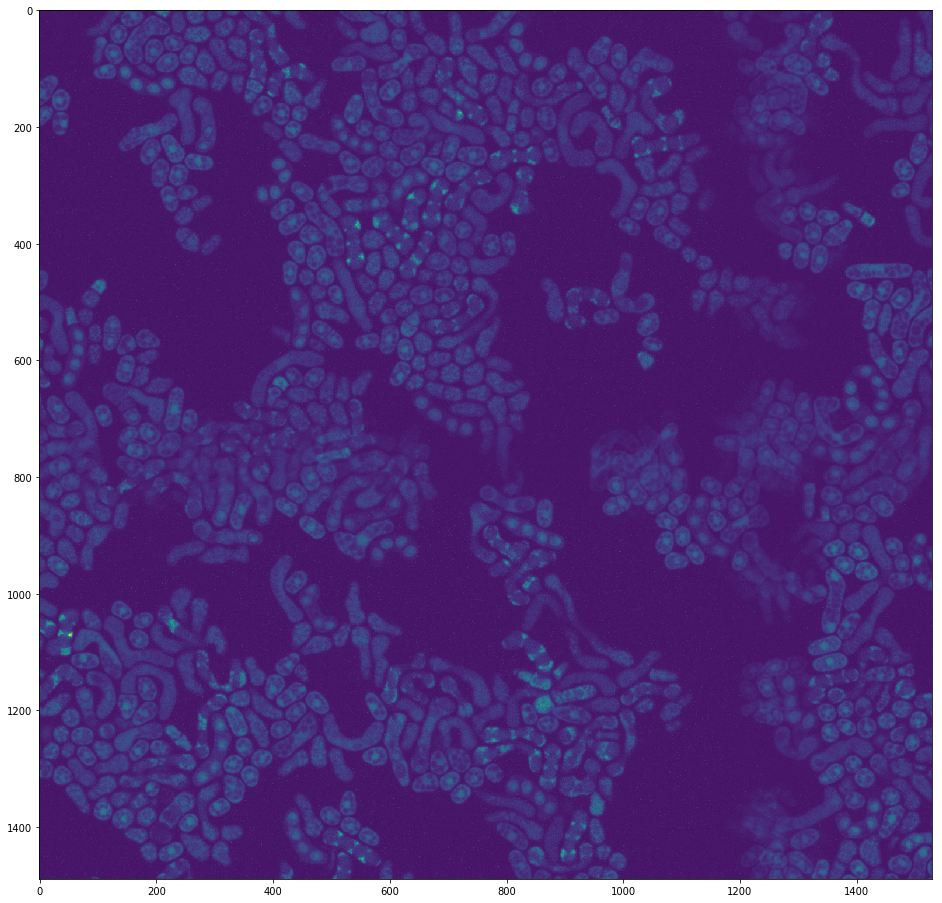

In [32]:
# data_raw = imread('/Users/cjw/Data/sez/RawTifs/10_hours_punched_overnight/NDExp_Point0017_Seq0017.tif')
data_raw = imread('/ssd1/cjw/Data/sez/pombeXkambucha-3.tif')
data_raw = data_raw[:,:,:]
# data_raw = np.expand_dims(data_raw, -1)
dmin = data_raw.min(axis=(0,1),keepdims=True)
dmax = data_raw.max(axis=(0,1),keepdims=True)
#data = (data_raw - dmin)/(dmax - dmin)

ymean = data_raw.mean(axis=(0,1), keepdims=True)
ystd = data_raw.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
data = (data_raw - ymean)/ystd

plt.figure(figsize=(16,16))
plt.imshow(data[:,:,1] + data[:,:,0])
print(data_raw.shape, dmin.shape, dmax.shape)

In [11]:
def decode(patches):
    ds = sess.run(decoder, feed_dict={images:patches})
    return ds

        
def image_to_patches(image, w):
    
    ny, nx, nc = image.shape
    
    patch_list = list()
    xmax = 0
    ymax = 0
    xok = True
    yok = True
    while xok:
        yok = True
        ymax = 0
        xs = xmax
        xmax += w
        if xmax >= nx:
            xmax = nx
            xs = nx - w
            xok = False
        while yok:
            ys = ymax
            ymax += w
            if ymax > ny:
                ymax = ny
                ys = ny - w
                yok = False
            #print(ys, ymax, yok, xs, xmax, xok)
            p = np.expand_dims(image[ys:ymax, xs:xmax, :], 0)
            patch_list.append(p)
    
    patches = np.concatenate(patch_list, axis=0)
    print(patches.shape)
    return  patches

def patches_to_image(patches, w, nx, ny):
    
    image = np.zeros((ny, nx, patches.shape[-1]), dtype=patches.dtype)
    xmax = 0
    ymax = 0
    xok = True
    yok = True
    patch_index = 0
    while xok:
        ymax = 0
        yok = True
        xs = xmax
        xmax += w
        if xmax >= nx:
            xmax = nx
            xs = nx - w
            xok = False
        while yok:
            ys = ymax
            ymax += w
            if ymax > ny:
                ymax = ny
                ys = ny - w
                yok = False
            
            image[ys:ymax, xs:xmax, :] = patches[patch_index]
            patch_index += 1
            #print(patch_index, ys, ymax, xs, xmax, yok, xok)
    return image

In [12]:
import time

t1 = time.time()
p = image_to_patches(data, 256)
d2 = data[128:, 128:, :]
p2 = image_to_patches(d2, 256)
dp = decode(p)
dp2 = decode(p2)
ndp = dp.shape[0]

dp[:,0:2,:,:] = 0
dp[:,:,0:2,:] = 0
dp[:,-2:-1,:,:] = 0
dp[:,:,-2:-1,:] = 0

dp2[:,0:2,:,:] = 0
dp2[:,:,0:2,:] = 0
dp2[:,-2:-1,:,:] = 0
dp2[:,:,-2:-1,:] = 0

r1 = patches_to_image(dp, 256, data.shape[1] , data.shape[0])
r2 = patches_to_image(dp2, 256, data.shape[1] - 128, data.shape[0] - 128)

rr2 = r1*0
rr2[128:, 128:, :] = r2

rstack = np.stack((r1, rr2), axis=0)

r = rstack.max(axis=0)

print(time.time()  - t1)


(36, 256, 256, 3)
(36, 256, 256, 3)
1.6658387184143066


(1489, 1530, 3)


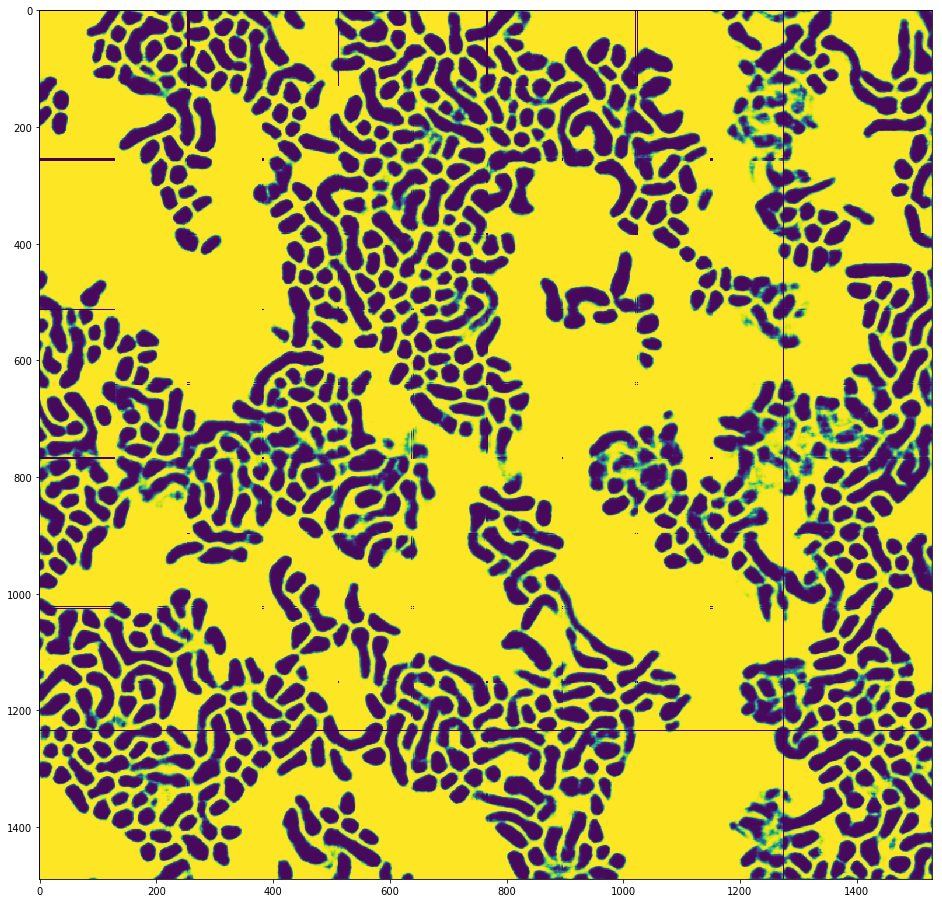

In [27]:
#plt.cla()
tr = r > .5
#tr = tr.astype(np.int32)
#tr = 255*tr
print(tr.shape)
plt.figure(figsize=(16, 16))

plt.imshow(r[:,:,1])


In [18]:
import tifffile
tifffile.imsave('/ssd1/cjw/Data/sez/pk-3.tif', np.moveaxis(r, -1, 0))

(1, 256, 256, 3)


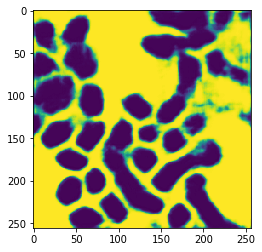

In [26]:
xg = 900 + 128
yg = 700

dr = np.expand_dims(data[yg:yg + 256, xg:xg+256,:], 0)
# dr = np.expand_dims(dr, -1)
da = decode(dr)
print(da.shape)
plt.imshow(((0*da[0,:,:,0] + da[0,:,:,1])/1))